## AMES Housing Project 
<hr/>

### 2 - Modelling and Predictions

### Content:
* [Tuning hyperparameters and getting optimal alphas](#alpha)
* [Model Scores - Train](#mstrain)
* [Model Scores - Test](#mstest)
* [Model Evaluation](#meval)
* [Feature Selection using Lasso](#non0)
* [Building Production Model - Submission to Kaggle](#kaggle)
* [Conclusion and Recommendations](#conc)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
# import data

train_df = pd.read_csv('datasets/train_final.csv', keep_default_na=False)

In [3]:
train_df.head()

,Unnamed: 0,id,mssubclass,lotconfig,neighborhood,bldgtype,housestyle,yearbuilt,yearremod/add,roofstyle,...,fullbath,totrmsabvgrd,garagefinish,garagecars,saletype,saleprice,agesold,total_sqft,totalqual,combined_exterior
0,0,109,60,CulDSac,Sawyer,1Fam,2Story,1976,2005,Gable,...,2,6,2.0,2.0,WD,130500,34,2679.0,17.0,HdBoardPlywood
1,1,544,60,CulDSac,SawyerW,1Fam,2Story,1996,1997,Gable,...,2,8,2.0,2.0,WD,220000,13,3594.0,19.0,VinylSdVinylSd
2,2,153,20,Inside,NAmes,1Fam,1Story,1953,2007,Gable,...,1,5,1.0,1.0,WD,109000,57,2360.0,15.0,VinylSdVinylSd
3,3,318,60,Inside,Timber,1Fam,2Story,2006,2007,Gable,...,2,7,3.0,2.0,WD,174000,4,2228.0,15.0,VinylSdVinylSd
4,4,255,50,Inside,SawyerW,1Fam,1.5Fin,1900,1993,Gable,...,2,6,1.0,2.0,WD,138500,110,2605.0,14.0,Wd SdngPlywood


In [4]:
train_df.shape

(2048, 26)

In [5]:
train_df = train_df.drop('Unnamed: 0', axis=1) #drop the extra axis that was generated

In [6]:
train_df.dtypes

id                     int64
mssubclass             int64
lotconfig             object
neighborhood          object
bldgtype              object
housestyle            object
yearbuilt              int64
yearremod/add          int64
roofstyle             object
roofmatl              object
masvnrtype            object
masvnrarea           float64
foundation            object
totalbsmtsf          float64
grlivarea              int64
fullbath               int64
totrmsabvgrd           int64
garagefinish         float64
garagecars           float64
saletype              object
saleprice              int64
agesold                int64
total_sqft           float64
totalqual            float64
combined_exterior     object
dtype: object

In [7]:
train_df['mssubclass'] = train_df['mssubclass'].astype(str) #reconvert mssubclass into string

#### Setting variables

In [8]:
X = train_df.drop('saleprice', axis=1)
y = train_df['saleprice']

In [9]:
#create list of categorical and non categorical features
cat = ['lotconfig', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'masvnrtype', 
        'neighborhood','foundation', 'saletype', 'combined_exterior', 'mssubclass']
non_cat = [x for x in train_df.columns if x not in cat]

In [10]:
non_cat.remove('saleprice')

In [11]:
non_cat.remove('id')

#### Train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
X_train.shape

(1536, 24)

In [14]:
X_test.shape

(512, 24)

#### Scaling (without categorical features)

In [15]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train[non_cat]) #We do not transform categorical
X_test_scaled = ss.transform(X_test[non_cat]) 

#### Encode categorical features and merge them back

In [16]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train[non_cat].columns)

In [17]:
# encoding categorical variables
X_train_cat = pd.get_dummies(X_train[cat], drop_first=True).reset_index(drop=True)

In [18]:
X_train_transformed = pd.concat([X_train_scaled, X_train_cat], axis=1)

In [19]:
X_train_transformed.shape

(1536, 157)

In [20]:
X_train_transformed.isnull().sum().sum()

0

#### Repeat similar process for test

In [21]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test[non_cat].columns)

In [22]:
X_test_cat = pd.get_dummies(X_test[cat],drop_first=True).reset_index(drop=True)

In [23]:
X_test_transformed = pd.concat([X_test_scaled, X_test_cat], axis=1)

In [24]:
X_test_transformed.shape

(512, 127)

In [25]:
X_test_transformed.isnull().sum().sum()

0

Here we see that the shape of X_test and X_train looks different. We need to fix this. One way is to declare a dummy column with 0 values. Another way is to look at the intersection of the 2 columns and find common ones.

In [26]:
new_columns = set(X_train_transformed.columns) & set(X_test_transformed.columns)

In [27]:
len(new_columns)

117

In [28]:
X_train_transformed = X_train_transformed[new_columns] #setting same amount of features for X train and Xtest

In [29]:
X_test_transformed = X_test_transformed[new_columns] #setting same amount of features for X train and Xtest

In [30]:
X_train_transformed.shape

(1536, 117)

In [31]:
X_test_transformed.shape

(512, 117)

Now we can use these to evaluate our models.

### Tuning the hyperparameters and getting the optimal alphas <a class="anchor" id="alpha"></a>

#### Lasso 

In [32]:
lassocv = LassoCV(n_alphas = 200, cv = 5)
lassocv = lassocv.fit(X_train_transformed, y_train)

print('optimal lasso alpha: ', lassocv.alpha_)
print('lasso R2: ', lassocv.score(X_train_transformed, y_train))

optimal lasso alpha:  66.72987873883862
lasso R2:  0.889386916205149


#### Ridge

In [33]:
r_alpha = np.logspace (0,5,200)

ridgecv = RidgeCV(alphas = r_alpha, cv = 5)
ridgecv = ridgecv.fit(X_train_transformed, y_train)

print('optimal ridge alpha: ', ridgecv.alpha_)
print('ridge R2: ', ridgecv.score(X_train_transformed, y_train))

optimal ridge alpha:  3.5707859649004634
ridge R2:  0.8935175275337304


#### Creating functions to calculate RMSE and R2

In [34]:
def rmse(model, X, y):
    result = -cross_val_score(model, 
                             X, 
                             y, 
                             cv=5, scoring = 'neg_mean_squared_error').mean()
    return 'RMSE:', np.sqrt(result)

In [35]:
def r2_score(model, X, y):
    model.fit(X, y)
    result = model.score(X, y)
    return 'r2: ', result

In [36]:
#defining models
lr = LinearRegression()
ridge = Ridge(alpha = ridgecv.alpha_)
lasso = Lasso(alpha = lassocv.alpha_)

### Model scores - Train <a class="anchor" id="mstrain"></a>

#### Linear Regression

In [37]:
#RMSE for linear regression 
rmse(lr, X_train_transformed, y_train)

('RMSE:', 6.282412075511655e+16)

In [38]:
#r2 for linear regression
r2_score(lr, X_train_transformed, y_train)

('r2: ', 0.8952681519255281)

The RMSE score looks very large. This likely means that some features we chose might not be following a normal distribution and therefore the relationship between the features and sale price is not linear. This could also be due to the fact that there might be some multicollinearity between the features.

#### Lasso

In [39]:
#RMSE for lasso 
rmse(lasso, X_train_transformed, y_train)

('RMSE:', 27811.859526383792)

In [40]:
#r2 for linear
r2_score(lasso, X_train_transformed, y_train)

('r2: ', 0.889386916205149)

We see that Lasso model has a much lesser RMSE than Linear, this was likely because a penalty term was applied to zero out some features.

#### Ridge

In [41]:
#RMSE for ridge
rmse(ridge, X_train_transformed, y_train)

('RMSE:', 27625.59834285606)

In [42]:
#r2 for ridge
r2_score(ridge, X_train_transformed, y_train)

('r2: ', 0.8935175275337304)

We see that ridge achieves the lowest RMSE out of all 3 models for training, and has a higher r2 score, which implies ridge model can explain 89% of the variations in saleprice.

### Model scores - Test <a class="anchor" id="mstest"></a>

In [43]:
#figuring out the baseline
from sklearn.dummy import DummyRegressor
dummy_regressor = DummyRegressor()
baseline_mod = dummy_regressor.fit(X_train, y_train)
baseline_pred = dummy_regressor.predict(X_test)

print(f'baseline R2: {dummy_regressor.score(X_test, y_test)}')
print(f'baseline RMSE: {np.sqrt(metrics.mean_squared_error(y_test, baseline_pred))}')

baseline R2: -0.0003877677025097004
baseline RMSE: 81732.4755447888


#### Linear Regression

In [44]:
#fit the data
lr = lr.fit(X_train_transformed, y_train)

In [45]:
# predict 
y_pred_lr = lr.predict(X_test_transformed)

In [46]:
print('lr r2:', lr.score(X_test_transformed, y_test))
print('lr RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))

lr r2: 0.8892987680354176
lr RMSE: 27188.590512993793


Our Linear Regression model seems to perform much better on the hold out set. 

#### Lasso Regression

In [47]:
#fit the data
lasso = lasso.fit(X_train_transformed, y_train)

In [48]:
# predict 
y_pred_lasso = lasso.predict(X_test_transformed)

In [49]:
print('lasso r2:', lasso.score(X_test_transformed, y_test))
print('lasso RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso)))

lasso r2: 0.8863671467811685
lasso RMSE: 27546.246063733255


We see that the Lasso model has also performed better on the holdout set.

#### Ridge Regression

In [50]:
#fit the data
ridge = ridge.fit(X_train_transformed, y_train)

In [51]:
# predict 
y_pred_ridge = ridge.predict(X_test_transformed)

In [52]:
print('ridge r2:', ridge.score(X_test_transformed, y_test))
print('ridge RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))

ridge r2: 0.8908772470902031
ridge RMSE: 26994.05470482014


We see that the Ridge model has also performed better on the holdout set. Overall, ridge regression model has the lowest RMSE and highest r2 score among the other models for both the train and test(holdout) sets.

### Model evaluation <a class="anchor" id="meval"></a>

| Model |R2   | RMSE  |
| :------|:----- | :----- |
| Linear(train) | 0.89526  |6.282412075511655e+16 |
| Linear(test) | 0.88929 | 27188.5905  |
| Lasso(train) | 0.88938 | 27811.8595 |
| Lasso(test) | 0.88636 | 27546.2460|
| Ridge (train) | 0.89351 | 27625.5983  |
| Ridge (test) | 0.89087 | 26994.0547 |
| Dummy(baseline) | -0.0003877 | 81732.4755 |

Overall, we can see from the table that all models have performed above the baseline, except for linear regression. Comparing the R2 and RMSE across the different models for the train and test (holdout) sets, ridge is the best model thus far. 

#### Residual plot and predicted value distribution of Ridge 

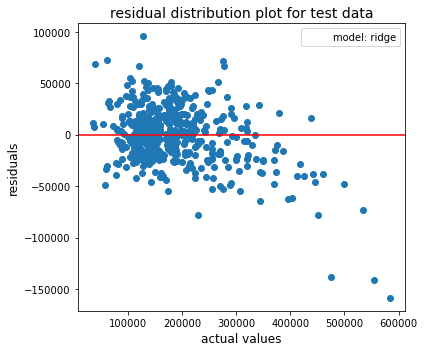

In [53]:
residual = y_pred_ridge - y_test

plt.figure(figsize=(6,5))
plt.scatter(y_test, residual)
plt.axhline(0, linestyle='-', color='r')
plt.title('residual distribution plot for test data',fontsize=14)
plt.xlabel('actual values',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.plot([], [], ' ', label="model: ridge")
plt.legend()
plt.tight_layout()

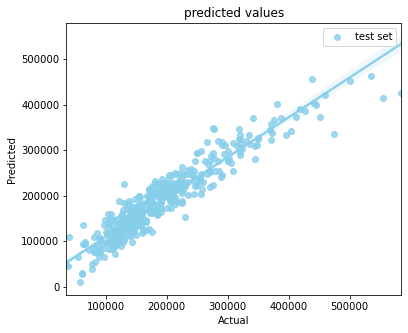

In [54]:
# plot ypred vs ytrue
plt.figure(figsize=(6,5))
ax = plt.gca()
sns.regplot(x= y_test, y= y_pred_ridge, color='skyblue', ax=ax, label="test set")
ax.set_title('predicted values', fontsize=12)
ax.legend()
ax.set(xlabel='Actual', ylabel='Predicted');

We see from the residual plot that there is generally equal distribution, and the data seems to be clustered near the middle/red line. The predicted values vs actual values plot also shows us a generally linear relationship.

### Feature selection using Lasso <a class="anchor" id="non0"></a>

Fitting the model into lasso regression earlier has helped us zero out features that are not so useful to us. Let us take a look at these features before we go into production building for our final model.

In [55]:
#taking a look at the lasso coefficients
lasso_df = pd.DataFrame(zip(lasso.coef_, abs(lasso.coef_), X_train_transformed.columns), 
                        columns = ['coefficient', 'abs coeff', 'features']) 

In [56]:
pd.set_option('display.max_rows', len(lasso_df))

In [57]:
#looking at the non zeroed features based on absolute coefficient
lasso_df.sort_values(by='abs coeff', ascending=False)

,coefficient,abs coeff,features
3,47790.957876,47790.957876,neighborhood_StoneBr
69,34306.262823,34306.262823,foundation_Slab
104,-30150.859399,30150.859399,roofstyle_Mansard
112,27135.967083,27135.967083,totalqual
79,26041.787888,26041.787888,roofmatl_WdShngl
26,25161.328628,25161.328628,neighborhood_NridgHt
97,24922.237173,24922.237173,total_sqft
108,22615.181251,22615.181251,neighborhood_GrnHill
24,-20430.083563,20430.083563,bldgtype_TwnhsE
19,16878.694652,16878.694652,saletype_New


In [58]:
lasso_df.groupby('abs coeff')['abs coeff'].value_counts()

abs coeff     abs coeff   
0.000000      0.000000        53
239.695394    239.695394       1
327.702143    327.702143       1
342.712702    342.712702       1
697.709643    697.709643       1
773.315850    773.315850       1
808.653973    808.653973       1
943.882680    943.882680       1
1135.701054   1135.701054      1
1146.507567   1146.507567      1
1169.522127   1169.522127      1
1741.969221   1741.969221      1
1885.128038   1885.128038      1
1975.503632   1975.503632      1
1993.170488   1993.170488      1
2104.730312   2104.730312      1
2163.951599   2163.951599      1
2449.257609   2449.257609      1
2587.297551   2587.297551      1
2828.889102   2828.889102      1
2915.019050   2915.019050      1
3032.162672   3032.162672      1
3196.777080   3196.777080      1
3205.940661   3205.940661      1
3386.088882   3386.088882      1
3561.904989   3561.904989      1
3570.668475   3570.668475      1
3600.135964   3600.135964      1
3912.860534   3912.860534      1
4492.303195   44

Here we can see that the lasso model has dropped about 53 features from our original 117, which leaves us with about 64 features. Additionally, from this table, we can see that total square feet, total quality, neighbourhood and material related features(e.g. roof, foundation) affect the sale price of a property greatly.

In [59]:
len(lasso.coef_[abs(lasso.coef_) > 0])

64

In [60]:
#look at 
lasso1_features = X_train_transformed.columns[abs(lasso.coef_) > 0]

Since lasso regression has helped us remove some features, we now select the features not zeored out by lasso. We will proceed to use these features to test the models.

In [61]:
X_train_lassoed = X_train_transformed[lasso1_features]
X_test_lassoed = X_test_transformed[lasso1_features]

In [62]:
#figuring out the baseline
from sklearn.dummy import DummyRegressor
dummy_regressor = DummyRegressor()
baseline_mod = dummy_regressor.fit(X_train_lassoed, y_train)
baseline_pred = dummy_regressor.predict(X_test_lassoed)

print(f'baseline R2: {dummy_regressor.score(X_test_lassoed, y_test)}')
print(f'baseline RMSE: {np.sqrt(metrics.mean_squared_error(y_test, baseline_pred))}')

baseline R2: -0.0003877677025097004
baseline RMSE: 81732.4755447888


#### Linear Regression

In [63]:
#fit the model
lr = lr.fit(X_train_lassoed, y_train)

In [64]:
#RMSE for linear regression train
rmse(lr, X_train_lassoed, y_train)

('RMSE:', 13972676019.060116)

In [65]:
#r2 for linear regression train
r2_score(lr, X_train_lassoed, y_train)

('r2: ', 0.8939902618240614)

In [66]:
#predict
y_preds_linear1 = lr.predict(X_test_lassoed)

In [67]:
# R2 and RMSE for linear regression test
print('lr r2:', lr.score(X_test_lassoed, y_test))
print('lr RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_preds_linear1)))

lr r2: 0.8874168524310587
lr RMSE: 27418.71895531701


The model performs terribly on train sets but performs surprisingly well on test.This is similar to what we observed in our earlier evaluation.

#### Ridge Regression

In [68]:
#get new optimal alpha
r_alpha = np.logspace (0,5,200)

ridgecv = RidgeCV(alphas = r_alpha, cv = 5)
ridgecv = ridgecv.fit(X_train_lassoed, y_train)

print('optimal ridge alpha: ', ridgecv.alpha_)
print('ridge R2: ', ridgecv.score(X_train_lassoed, y_train))

optimal ridge alpha:  1.3354515629298989
ridge R2:  0.8928832405585494


In [69]:
ridge = Ridge(alpha = ridgecv.alpha_)

In [70]:
#fit the model
ridge.fit(X_train_lassoed, y_train)

Ridge(alpha=1.3354515629298989)

In [71]:
#RMSE for ridge
rmse(ridge, X_train_lassoed, y_train)

('RMSE:', 27382.11582732623)

In [72]:
#r2 for ridge
r2_score(ridge, X_train_lassoed, y_train)

('r2: ', 0.8928832405585494)

In [73]:
#predict
y_preds_ridge1 = ridge.predict(X_test_lassoed)

In [74]:
# R2 and RMSE for linear regression test
print('ridge r2:', ridge.score(X_test_lassoed, y_test))
print('ridge RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_preds_ridge1)))

ridge r2: 0.8886306789028453
ridge RMSE: 27270.50955797933


Similar to earlier observations, ridge has consistently performed well on the training and testing(holdout) sets.

#### Lasso Regression

In [75]:
#get new optimal alpha
lassocv = LassoCV(n_alphas = 200, cv = 5)
lassocv = lassocv.fit(X_train_lassoed, y_train)

print('optimal lasso alpha: ', lassocv.alpha_)
print('lasso R2: ', lassocv.score(X_train_lassoed, y_train))

optimal lasso alpha:  66.72987873883862
lasso R2:  0.8893830835156565


In [76]:
lasso = Lasso(alpha = lassocv.alpha_)

In [77]:
#fit the model
lasso.fit(X_train_lassoed, y_train)

Lasso(alpha=66.72987873883862)

In [78]:
#RMSE for lasso train
rmse(lasso, X_train_lassoed, y_train)

('RMSE:', 27715.40814930706)

In [79]:
#r2 for lasso train
r2_score(lasso, X_train_lassoed, y_train)

('r2: ', 0.8893830835156565)

In [80]:
#predict
y_preds_lasso1 = lasso.predict(X_test_lassoed)

In [81]:
# R2 and RMSE for linear regression test
print('lasso r2:', lasso.score(X_test_lassoed, y_test))
print('lasso RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_preds_lasso1)))

lasso r2: 0.886356292730526
lasso RMSE: 27547.56162169876


Ridge regression still works the best, comparing across scores for train and test (holdout) sets.

## Building production model (Submission to Kaggle) <a class="anchor" id="kaggle"></a>

Loading the train and test csv files

In [82]:
#load test.csv
test_df = pd.read_csv('datasets/test_final.csv', keep_default_na=False)

In [83]:
test_df.head()

,Unnamed: 0,id,mssubclass,lotconfig,neighborhood,bldgtype,housestyle,yearbuilt,yearremod/add,roofstyle,...,grlivarea,fullbath,totrmsabvgrd,garagefinish,garagecars,saletype,agesold,total_sqft,totalqual,combined_exterior
0,0,2658,190,Inside,OldTown,2fmCon,2Story,1910,1950,Gable,...,1928,2,9,1.0,1,WD,96,3388,13.0,AsbShngAsbShng
1,1,2718,90,Inside,Sawyer,Duplex,1Story,1977,1977,Gable,...,1967,2,10,3.0,2,WD,29,4514,15.0,PlywoodPlywood
2,2,2414,60,Inside,Gilbert,1Fam,2Story,2006,2006,Gable,...,1496,2,7,2.0,2,New,0,2576,19.0,VinylSdVinylSd
3,3,1989,30,Inside,OldTown,1Fam,1Story,1923,2006,Gable,...,968,1,5,1.0,2,WD,84,2416,15.0,Wd SdngWd Sdng
4,4,625,20,Inside,NAmes,1Fam,1Story,1963,1963,Gable,...,1394,1,6,2.0,2,WD,46,3302,16.0,PlywoodPlywood


In [84]:
#dropping unnamed column 
test_df = test_df.drop('Unnamed: 0', axis=1)

In [85]:
#converting mssubclass to string again as it changes back to int after being read into a DataFrame
test_df['mssubclass'] = test_df['mssubclass'].astype(str) 

In [86]:
# importing train csv
train_df = pd.read_csv('datasets/train_final.csv', keep_default_na=False)

In [87]:
train_df.head()

,Unnamed: 0,id,mssubclass,lotconfig,neighborhood,bldgtype,housestyle,yearbuilt,yearremod/add,roofstyle,...,fullbath,totrmsabvgrd,garagefinish,garagecars,saletype,saleprice,agesold,total_sqft,totalqual,combined_exterior
0,0,109,60,CulDSac,Sawyer,1Fam,2Story,1976,2005,Gable,...,2,6,2.0,2.0,WD,130500,34,2679.0,17.0,HdBoardPlywood
1,1,544,60,CulDSac,SawyerW,1Fam,2Story,1996,1997,Gable,...,2,8,2.0,2.0,WD,220000,13,3594.0,19.0,VinylSdVinylSd
2,2,153,20,Inside,NAmes,1Fam,1Story,1953,2007,Gable,...,1,5,1.0,1.0,WD,109000,57,2360.0,15.0,VinylSdVinylSd
3,3,318,60,Inside,Timber,1Fam,2Story,2006,2007,Gable,...,2,7,3.0,2.0,WD,174000,4,2228.0,15.0,VinylSdVinylSd
4,4,255,50,Inside,SawyerW,1Fam,1.5Fin,1900,1993,Gable,...,2,6,1.0,2.0,WD,138500,110,2605.0,14.0,Wd SdngPlywood


In [88]:
train_df = train_df.drop('Unnamed: 0', axis=1)

In [89]:
train_df['mssubclass'] = train_df['mssubclass'].astype(str) 

#### Scaling numerical features (train)

In [90]:
Xtrain = train_df.drop('saleprice', axis=1)
Xtest = test_df

In [91]:
Xtrain_scaled = ss.fit_transform(Xtrain[non_cat])
Xtest_scaled = ss.transform(Xtest[non_cat])

In [92]:
Xtrain_scaled = pd.DataFrame(Xtrain_scaled, columns=Xtrain[non_cat].columns)

#### Encoding categorical features (train)

In [93]:
Xtrain_dum = pd.get_dummies(Xtrain[cat], drop_first=True).reset_index(drop=True)

In [94]:
#combining the scaled and encoded features 
Xtrain_combined = pd.concat([Xtrain_scaled, Xtrain_dum], axis=1)

In [95]:
Xtrain_combined.head()

,yearbuilt,yearremod/add,masvnrarea,totalbsmtsf,grlivarea,fullbath,totrmsabvgrd,garagefinish,garagecars,agesold,...,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,mssubclass_70,mssubclass_75,mssubclass_80,mssubclass_85,mssubclass_90
0,0.142701,0.990993,1.112216,-0.768828,-0.033745,0.770677,-0.277881,0.308944,0.293264,-0.068877,...,0,0,0,0,1,0,0,0,0,0
1,0.806005,0.610589,0.199016,-0.328333,1.290041,0.770677,1.017001,0.308944,0.293264,-0.764573,...,0,0,0,0,1,0,0,0,0,0
2,-0.620098,1.086095,-0.568771,0.009067,-0.902544,-1.049792,-0.925322,-0.804995,-1.015243,0.693075,...,0,0,0,0,0,0,0,0,0,0
3,1.137656,1.086095,-0.568771,-1.567811,-0.105802,0.770677,0.369560,1.422883,0.293264,-1.062728,...,0,0,0,0,1,0,0,0,0,0
4,-2.377853,0.420386,-0.568771,-0.883638,-0.103743,0.770677,-0.277881,-0.804995,0.293264,2.448878,...,0,0,0,1,0,0,0,0,0,0


In [96]:
#checking for null values after concatenating
Xtrain_combined.isnull().sum().sum()

0

#### Scaling numerical features (Xtest)

In [97]:
Xtest_scaled = pd.DataFrame(Xtest_scaled, columns=Xtest[non_cat].columns)

In [98]:
Xtest_dum = pd.DataFrame(Xtest[cat], columns=Xtest[cat].columns)

#### Custom encoder for Xtest dataset

The function below was borrowed after doing some research online. I decide to manually encode the test dataset as I repeatedly encountered problems when I used pd.get_dummies directly on the dataframe, e.g. missing columns. To use the function below, we first need to declare the categorical variable, then append the related column names into a list if they can be found in lasso1_features before we call the function to encode the categorical variables one by one.

In [99]:
def custom_encoder(df, cat_var, dummies):
    checklist = []
    for dummy in dummies:
        df[dummy] = 0
        checklist.append(dummy.split('_')[1])
    for idx, value in enumerate(df[cat_var]):
        if value in checklist:
            df.loc[[idx], [cat_var + '_' + value]] = 1
        else:
            pass
    return df.drop(columns=cat_var)

In [100]:
# declare variable and check if related variable names are in lassoed features list.
cat_var = 'mssubclass'
mssubclass_dummies = [f for f in lasso1_features if cat_var in f] #if yes, append to dummies list
mssubclass_dummies

['mssubclass_30',
 'mssubclass_50',
 'mssubclass_60',
 'mssubclass_20',
 'mssubclass_90',
 'mssubclass_160']

In [101]:
# call function to encode categorical variable
Xtest_dum = custom_encoder(Xtest, 'mssubclass', mssubclass_dummies)

In [102]:
cat_var= 'lotconfig'
lotconfig_dummies = [f for f in lasso1_features if cat_var in f]
lotconfig_dummies

['lotconfig_CulDSac', 'lotconfig_Inside']

In [103]:
Xtest_dum = custom_encoder(Xtest, 'lotconfig', lotconfig_dummies)

In [104]:
cat_var= 'bldgtype'
bldgtype_dummies = [f for f in lasso1_features if cat_var in f]
bldgtype_dummies

['bldgtype_TwnhsE', 'bldgtype_Twnhs', 'bldgtype_Duplex']

In [105]:
Xtest_dum = custom_encoder(Xtest, 'bldgtype', bldgtype_dummies)

In [106]:
cat_var= 'housestyle'
housestyle_dummies = [f for f in lasso1_features if cat_var in f]
housestyle_dummies

['housestyle_2.5Unf', 'housestyle_SLvl', 'housestyle_2Story']

In [107]:
Xtest_dum = custom_encoder(Xtest, 'housestyle', housestyle_dummies)

In [108]:
cat_var= 'roofstyle'
roofstyle_dummies = [f for f in lasso1_features if cat_var in f]
roofstyle_dummies

['roofstyle_Hip', 'roofstyle_Gable', 'roofstyle_Mansard']

In [109]:
Xtest_dum = custom_encoder(Xtest, 'roofstyle', roofstyle_dummies)

In [110]:
cat_var= 'roofmatl'
roofmatl_dummies = [f for f in lasso1_features if cat_var in f]
roofmatl_dummies

['roofmatl_WdShngl']

In [111]:
Xtest_dum = custom_encoder(Xtest, 'roofmatl', roofmatl_dummies)

In [112]:
cat_var= 'masvnrtype'
masvnrtype_dummies = [f for f in lasso1_features if cat_var in f]
masvnrtype_dummies

['masvnrtype_Stone', 'masvnrtype_BrkFace', 'masvnrtype_None']

In [113]:
Xtest_dum = custom_encoder(Xtest, 'masvnrtype', masvnrtype_dummies)

In [114]:
cat_var= 'neighborhood'
neighborhood_dummies = [f for f in lasso1_features if cat_var in f]
neighborhood_dummies

['neighborhood_StoneBr',
 'neighborhood_SawyerW',
 'neighborhood_CollgCr',
 'neighborhood_Crawfor',
 'neighborhood_NridgHt',
 'neighborhood_IDOTRR',
 'neighborhood_Edwards',
 'neighborhood_Mitchel',
 'neighborhood_OldTown',
 'neighborhood_NAmes',
 'neighborhood_NWAmes',
 'neighborhood_NPkVill',
 'neighborhood_Timber',
 'neighborhood_Somerst',
 'neighborhood_Gilbert',
 'neighborhood_NoRidge',
 'neighborhood_ClearCr',
 'neighborhood_BrkSide',
 'neighborhood_GrnHill']

In [115]:
Xtest_dum = custom_encoder(Xtest, 'neighborhood', neighborhood_dummies)

In [116]:
cat_var= 'foundation'
foundation_dummies = [f for f in lasso1_features if cat_var in f]
foundation_dummies

['foundation_Slab', 'foundation_CBlock']

In [117]:
Xtest_dum = custom_encoder(Xtest, 'foundation', foundation_dummies)

In [118]:
cat_var= 'saletype'
saletype_dummies = [f for f in lasso1_features if cat_var in f]
saletype_dummies

['saletype_CWD', 'saletype_New', 'saletype_Con', 'saletype_WD ']

In [119]:
Xtest_dum = custom_encoder(Xtest, 'saletype', saletype_dummies)

In [120]:
cat_var = 'combined_exterior'
combined_exterior_dummies = [f for f in lasso1_features if cat_var in f]
combined_exterior_dummies

['combined_exterior_MetalSdMetalSd',
 'combined_exterior_HdBoardHdBoard',
 'combined_exterior_CemntBdCemntBd',
 'combined_exterior_VinylSdVinylSd',
 'combined_exterior_BrkFaceBrkFace',
 'combined_exterior_BrkFaceWd Sdng',
 'combined_exterior_Wd SdngWd Sdng',
 'combined_exterior_BrkCommBrk Cmn']

In [121]:
Xtest_dum = custom_encoder(Xtest, 'combined_exterior', combined_exterior_dummies)

Now that we are done with the manual encoding, we check the columns in the dataframe

In [122]:
Xtest_dum.head()

,id,mssubclass,lotconfig,neighborhood,bldgtype,housestyle,yearbuilt,yearremod/add,roofstyle,roofmatl,...,saletype_Con,saletype_WD,combined_exterior_MetalSdMetalSd,combined_exterior_HdBoardHdBoard,combined_exterior_CemntBdCemntBd,combined_exterior_VinylSdVinylSd,combined_exterior_BrkFaceBrkFace,combined_exterior_BrkFaceWd Sdng,combined_exterior_Wd SdngWd Sdng,combined_exterior_BrkCommBrk Cmn
0,2658,190,Inside,OldTown,2fmCon,2Story,1910,1950,Gable,CompShg,...,0,1,0,0,0,0,0,0,0,0
1,2718,90,Inside,Sawyer,Duplex,1Story,1977,1977,Gable,CompShg,...,0,1,0,0,0,0,0,0,0,0
2,2414,60,Inside,Gilbert,1Fam,2Story,2006,2006,Gable,CompShg,...,0,0,0,0,0,0,0,0,0,0
3,1989,30,Inside,OldTown,1Fam,1Story,1923,2006,Gable,CompShg,...,0,1,0,0,0,0,0,0,0,0
4,625,20,Inside,NAmes,1Fam,1Story,1963,1963,Gable,CompShg,...,0,1,0,0,0,0,0,0,0,0


We need to drop all the columns and leave only the encoded ones behind.

In [123]:
dropcols = non_cat + cat

In [124]:
dropcols.remove('combined_exterior')

In [125]:
#remove duplicate names
dropcols = list(set(dropcols))

In [126]:
#drop the columns not required
Xtest_dum = Xtest_dum.drop(dropcols, axis=1)

In [127]:
#drop id 
Xtest_dum = Xtest_dum.drop('id', axis=1)

Finally, we concatenate the scaled numerical features and encoded categorical features together.

In [128]:
Xtest_combined = pd.concat([Xtest_scaled, Xtest_dum], axis=1)

In [129]:
#Checking for null values
Xtest_combined.isnull().sum().sum()

0

### Fitting the model and initial look at the train RMSE and R2

In [130]:
Xtest_full = Xtest_combined[lasso1_features]  # we will use the features identified earlier

In [131]:
X_final = Xtrain_combined[lasso1_features] # we will use the features identified earlier

In [132]:
#fit
ridge.fit(X_final, y)

Ridge(alpha=1.3354515629298989)

In [133]:
#RMSE train 
rmse(ridge, X_final, y)

('RMSE:', 27343.120587491725)

In [135]:
#R2 train
r2_score(ridge, X_final, y)

('r2: ', 0.8934724479468832)

Our model seems to be able to predict the train data set quite well.

In [136]:
y_pred_train = ridge.predict(X_final)
y_pred_val = ridge.predict(Xtest_full)

In [139]:
#RMSE validation
np.sqrt(metrics.mean_squared_error(y, y_pred_train))

25880.10369842051

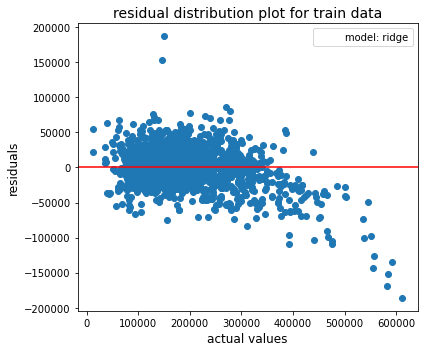

In [152]:
residual = y_pred_train - y

plt.figure(figsize=(6,5))
plt.scatter(y, residual)
plt.axhline(0, linestyle='-', color='r')
plt.title('residual distribution plot for train data',fontsize=14)
plt.xlabel('actual values',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.plot([], [], ' ', label="model: ridge")
plt.legend()
plt.tight_layout()

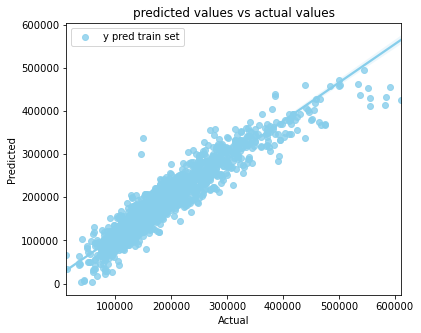

In [141]:
# plot ypred vs ytrue
plt.figure(figsize=(6,5))
ax = plt.gca()
sns.regplot(x= y, y= y_pred_train, color='skyblue', ax=ax, label="y pred train set")
ax.set_title('predicted values vs actual values', fontsize=12)
ax.legend()
ax.set(xlabel='Actual', ylabel='Predicted');

Looking at the residual plot, the data seems pretty symmetrically distributed, tending to cluster towards the middle of the plot. It looks like our current model is homoscedastic; meaning there is not a lot of variance, with the exception of a few outliers. Our actual vs predicted values scatter plot shows strong correlation between the model’s predictions and its actual results. This means our model does not seem to be overfitting, and should be able to predict and explain sale prices reasonably well.

We will now proceed to use the y_pred_val for submission to Kaggle.

### Submission to Kaggle

In [139]:
#retrieving the id
X_test_id = test_df.iloc[:, :1]

In [140]:
X_test_id

,id
0,2658
1,2718
2,2414
3,1989
4,625
...,...
874,1662
875,1234
876,1373
877,1672


In [141]:
#concatenating id with y_pred_val, our predicted saleprices for validation
sub_pred = pd.concat([X_test_id, pd.DataFrame(y_pred_val, columns=['saleprice'])], axis=1)

In [142]:
sub_pred.head()

,id,saleprice
0,2658,128681.749053
1,2718,201200.587297
2,2414,201830.772593
3,1989,127874.989054
4,625,180343.832721


In [143]:
sub_pred.shape

(879, 2)

In [144]:
sub_pred.to_csv('datasets/submission_predict.csv', index=False)

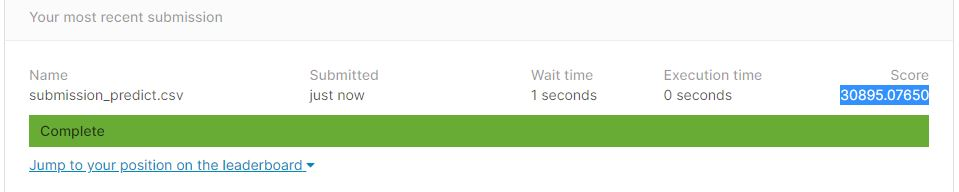

#### Hooray, our model achieved a score of about 30895. This is confirmation that our model generalises well on unseen data.

### Conclusion and recommendations <a class="anchor" id="conc"></a>

In our process of developing our production model for Ames property sale price predictions, we see that a few features have a huge influence in the sale price of a property: <br>
1) **Neighborhood**: The neighborhood the property is located in. <br> 
2) **Quality**: The overall finishing and material of the house. <br>
3) **Square Feet**: The size of the property. <br> 
4) **Materials e.g. Foundation, Roof** : The materials used to construct the property <br> 

Surprisingly, the age of the property did not influence the sale price as much as we initially assumed. Maintenance and remodelling of homes seemed to matter more, and could [add years to the useful life of a home.](https://www.adn.com/business-economy/2018/06/21/the-age-of-your-house-isnt-just-based-on-the-year-it-was-built-heres-why-thats-important-when-youre-selling-your-home/) <br>

Homeowners could consider doing some remodelling to increase the value of their property and maintain their homes. <br>

These neighborhoods in Ames seem like a good investment: 
1) **Stone Brook** : A few minutes drive from the [Iowa State University campus](https://www.stonebrooke.org/).  <br>
2) **Northridge Heights** : Located to thriving [Gilbert school district](https://www.hunzikerdevelopment.com/active-developments/northridge-heights/). <br> 
3) **Green Hills**: Retirement community for [Iowa State University alumni](https://greenhillsrc.com/about-us/).

We will not be able to generalise this model to other cities as the data seems to be Ames specific. To be able to generalise our model we would need more generic features to be included in the dataset such as distance to amenities, e.g. schools, malls etc. This seems to have some correlation to neighborhood as we observe from the top 3 neighborhoods for property investment in Ames.